<a href="https://colab.research.google.com/github/lina-conti/sentiment-analysis/blob/main/Conti_TP_2_word_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copy this notebook (File>Save a copy in Drive) and then work on your copy.
==
To send me your work: use the sharing menu (top-right of the window) to share it with timothee.m.r.bernard@gmail.com.
(I don't check this address very often, so, for questions, please use Moodle or my u-paris.fr address.)

Goal
==

We are about to design and train a neural system to perform sentiment analysis on film reviews. More precisely, the network will have to output the probability that the input review expresses a positive opinion (overall).

The system will be a bag-of-words model using GloVe embeddings. It will have to first average the embeddings of the words of the input review, and then send the result through a simple network that should output a probability.

There is a lot of code already written at the beginning of the notebook. It is important that you understand it as you will have to reuse/reproduce it for future work.

Loading PyTorch is important.
==

In [ ]:
# Imports PyTorch.
import torch

Remarks:
==
*   Follow the instructions very carefully. Do not ignore any comment.
*   Comment your code (including the role of all functions and the type of their arguments). A piece of code not appropriately commented can be considered incorrect (irrespectively of whether it works or not).
*   Indicate the shape of each tensor that you define.
*   Comment all the changes that you make. Any work that is not properly explained can be ignored.

Downloading the dataset
==
The dataset we are going to use is the Large Movie Review Dataset (https://ai.stanford.edu/~amaas/data/sentiment/).

Downloading the dataset and pre-processing it might take several minutes, so ask Colab to execute all cells while you are reading the code.

In [ ]:
# Downloads the dataset.
import urllib

tmp = urllib.request.urlretrieve("https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz")
filename = tmp[0]

In [ ]:
filename

'/tmp/tmpec0pwqo1'

In [ ]:
# Extracts the dataset.
import tarfile
tar = tarfile.open(filename)
tar.extractall()
tar.close()

In [ ]:
import os # Useful library to read files and inspect directories.

In [ ]:
# Shows which files and directories are present at the root of the file system.
for filename in os.listdir("."):
  print(filename)

.config
aclImdb
sample_data


In [ ]:
dataset_root = "aclImdb"
# Shows which files and directories are present at the root of the dataset directory.
for filename in os.listdir(dataset_root):
  print(filename)

imdbEr.txt
train
imdb.vocab
README
test


In [ ]:
# Shows several reviews.
dirname = os.path.join(dataset_root, "train", "pos") # "aclImdb/{train|test}/{neg|pos}"
for idx, filename in enumerate(os.listdir(dirname)):
  if(idx >= 5): break # Stops after the 5th file.
  
  print(filename)
  with open(os.path.join(dirname, filename)) as f:
    review = f.read()
    print(review)
  print()

4153_10.txt
this was a fantastic episode. i saw a clip from it on YouTube, and i vowed that should it ever show on TV, i would glue myself to the set in order to watch. i wound up watching it with a friend of mine, who happens to be gay, and the two of us cried at the end. this was a truly well-written, heartfelt episode of the forbidden love between two cops who, i felt, really were (in Coop's words) "the Lucky Ones". it is episodes like this one that really make Cold Case one of the most captivating and much-loved works of television magic on CBS. i anxiously await more episodes, and a re-run of "Forever Blue" because i will always watch it again and again.

3518_10.txt
Drum scene is wild! Cook, Jr. is unsung hero of this and many movies. Fantastic actor, great flick. A few twists that keep you moving. A must-see.

12003_10.txt
As a convert into the Church of Jesus Christ of Latter Day Saints, I try to absorb as much as I can of my new religion's history. I was invited to attend a sh

Preprocessing the dataset
==

In [ ]:
import nltk # Imports NLTK, an NLP library.
nltk.download('punkt') # Loads a module required for tokenization.
import collections # This library defines useful data structures. 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
newline = "<br />" # The reviews sometimes contain this HTLM tag to indicate a line break.
def preprocess(text):
  text = text.replace(newline, " ") # Replaces the newline HTML tag with a space.
  tokens = nltk.word_tokenize(text); # Converts the text to a list of tokens (strings).
  tokens = [token.lower() for token in tokens] # Lowercases all tokens.
  
  return tokens

# Reads and pre-processes the reviews.
dataset = {"train": [], "test": []}
binary_classes = {"neg": 0, "pos": 1}
for part_name, l in dataset.items():
  for class_name, value in binary_classes.items():
    path = os.path.join(dataset_root, part_name, class_name)
    print("Processing %s..." % path, end='');
    for filename in os.listdir(path):
        with open(os.path.join(path, filename)) as f:
          review_text = f.read()
          review_tokens = preprocess(review_text)
          
          l.append((review_tokens, value))
    print(" done")

Processing aclImdb/train/neg... done
Processing aclImdb/train/pos... done
Processing aclImdb/test/neg... done
Processing aclImdb/test/pos... done


In [ ]:
# Splits the train set into a proper train set and a development/validation set.
# 'dataset["train"]' happens to be a list composed of a certain number of negative examples followed by the same number of positive examples.
# We are going to use 3/4 of the original train set as our actual train set, and 1/4 as our development set.
# We want to keep balanced train and development sets, i.e. for both, half of the reviews should be positive and half should be negative.
if("dev" in dataset): print("This should only be run once.")
else:
  dev_set_half_size = int((len(dataset["train"]) / 4) / 2) # Half of a quarter of the training set size.
  dataset["dev"] = dataset["train"][:dev_set_half_size] + dataset["train"][-dev_set_half_size:] # Takes some negative examples at the beginning and some positive ones at the end.
  dataset["train"] = dataset["train"][dev_set_half_size:-dev_set_half_size] # Removes the examples used for the development set.

  for (part, data) in dataset.items():
    class_counts = collections.defaultdict(int)
    for (_, p) in data: class_counts[p] += 1
    print(f"{part}: {class_counts}")
  print("Train set split into train/dev.")

train: defaultdict(<class 'int'>, {0: 9375, 1: 9375})
test: defaultdict(<class 'int'>, {0: 12500, 1: 12500})
dev: defaultdict(<class 'int'>, {0: 3125, 1: 3125})
Train set split into train/dev.


Loading the word embeddings
==
We are going to use GloVe embeddings.

All word forms with a frequency below a given threshold are going to be considered unknown forms.

In [ ]:
# Computes the frequency of all word forms in the train set.
word_counts = collections.defaultdict(int)
for tokens, _ in dataset["train"]:
  for token in tokens: word_counts[token] += 1

print(word_counts)

defaultdict(<class 'int'>, {'well': 7246, ',': 206570, 'jesus': 224, 'of': 108910, 'montreal': 2, 'is': 82717, 'basically': 669, 'an': 16162, 'intelligent': 393, 'movie': 32480, '.': 204732, 'the': 250787, 'actors': 3276, 'are': 22816, 'indeed': 539, 'good': 11049, 'and': 122751, 'technical': 240, 'side': 890, 'okay': 540, 'but': 31887, 'although': 1867, 'i': 64715, 'was': 37867, 'very': 10500, 'interested': 511, 'in': 69863, 'topic': 117, 'like': 14728, 'to': 101169, 'think': 5409, 'discuss': 85, 'about': 13020, 'religion': 168, '(': 26461, 'am': 2076, 'atheist': 12, ')': 27032, 'it': 71682, 'hard': 1824, 'force': 371, 'myself': 865, 'watch': 5166, 'bitter': 111, 'my': 9222, 'opinion': 711, 'somehow': 587, 'unconsciously': 11, 'funny': 3146, 'end': 4162, 'why': 3981, 'this': 56609, 'so': 15130, 'incredibly': 479, 'boring': 1339, '?': 11923, 'do': 13190, "n't": 25056, 'know': 4589, 'just': 13334, 'not': 23710, 'recommendable': 11, 'bought': 325, 'a': 122201, 'set': 1713, '4': 717, 'dvd

In [ ]:
# Builds a vocabulary containing only those words present in the train set with a frequency above a given threshold.
count_threshold = 4;
vocabulary = set()
for word, count in word_counts.items():
    if(count > count_threshold): vocabulary.add(word)

print(vocabulary)
print(len(vocabulary))

{'castaways', 'metaphor', 'jayhawkers', 'quick', 'poiré', 'divya', 'observed', 'cabbage', 'projection', 'aneta', 'sims', 'co-worker', 'resentment', 'orlando', "'90", 'acutely', 'scene-stealing', 'predecessor', 'gate', 'nearer', 'better', 'antagonists', 'succubus', 'dalai', 'krabbé', 'loud', 'tremendous', 'sterile', 'enemies', 'sixty', 'tolkien', 'easygoing', 'dodger', 'entertains', 'ditch', 'mins', 'virtues', 'rippner', 'intervenes', 'post-production', 'recuperate', 'sang', "'d", 'lump', 'coastal', 'scathing', 'wackiness', 'handgun', 'attribute', 'willingness', 'demanding', 'dismemberment', 'motley', 'fervor', 'realizing', 'notoriously', 'unsavory', 'vol', 'certain', 'accomplices', 'smile', 'batman', 'monitored', 'dunaway', 'bastard', 'nea', 'outburst', 'weirdly', 'ugly', 'yoda', 'monogram', 'launch', 'dirtiest', 'dvds', 'sympathize', 'eyeball', 'casa', 'crashes', 'marlon', 'elicited', 'concrete', 'telephone', 'contempt', 'suv', 'schlock', "'80s", 'visible', 'biggest', 'sicko', 'implie

In [ ]:
import zipfile
import numpy as np

In [ ]:
# Returns a dictionary {word[String]: id[Integer]} and a list of Numpy arrays.
# `data_path` is the path of the directory containing the GloVe files (if None, 'glove.6B' is used)
# `max_size` is the number of word embeddings read (starting from the most frequent; in the GloVe files, the words are sorted)
# If `vocabulary` is specified (as a set of strings, or a dictionary from strings to integers), the output vocabulary contains 
    # the intersection of `vocabulary` and the words with a defined embedding. Otherwise, all words with a defined embedding are used.
def get_glove(dim=50, vocabulary=None, max_size=-1, data_path=None):
  dimensions = set([50, 100, 200, 300]) # Available dimensions for GloVe 6B
  fallback_url = 'http://nlp.stanford.edu/data/glove.6B.zip' # (Remember that in GloVe 6B, words are lowercased.)

  assert (dim in dimensions), (f'Unavailable GloVe 6B dimension: {dim}.')

  if(data_path is None): data_path = 'glove.6B'

  # Checks that the data is here, otherwise downloads it.
  if(not os.path.isdir(data_path)):
    #print('Directory "%s" does not exist. Creation.' % data_path)
    os.makedirs(data_path)
  
  glove_weights_file_path = os.path.join(data_path, f'glove.6B.{dim}d.txt')
  
  if(not os.path.isfile(glove_weights_file_path)):
    local_zip_file_path = os.path.join(data_path, os.path.basename(fallback_url))
  
    if(not os.path.isfile(local_zip_file_path)):
      print(f'Retreiving GloVe embeddings from {fallback_url}.')
      urllib.request.urlretrieve(fallback_url, local_zip_file_path)
    
    with zipfile.ZipFile(local_zip_file_path, 'r') as z:
      print(f'Extracting GloVe embeddings from {local_zip_file_path}.')
      z.extractall(path=data_path)
  
  assert os.path.isfile(glove_weights_file_path), (f"GloVe file {glove_weights_file_path} not found.")

  # Reads GloVe data.
  print('Reading GloVe embeddings.')
  new_vocabulary = {} # A dictionary {word[String]: id[Integer]}
  embeddings = [] # The list of embeddings (Numpy arrays)
  with open(glove_weights_file_path, 'r') as f:
    for line in f: # Each line consist of the word followed by a space and all of the coefficients of the vector separated by a space.
      values = line.split()

      # Here, I'm trying to detect where on the line the word ends and where the vector begins. As in some version(s) of GloVe words can contain spaces, this is not entirely trivial.
      vector_part = ' '.join(values[-dim:])
      x = line.find(vector_part)
      word = line[:(x - 1)]

      if((vocabulary is not None) and (not word in vocabulary)): # If a vocabulary was specified and if the word is not it…
        continue # …this word is skipped.

      new_vocabulary[word] = len(new_vocabulary)
      embedding = np.asarray(values[-dim:], dtype=np.float32)
      embeddings.append(embedding)

      if(len(new_vocabulary) == max_size): break
  print('(GloVe embeddings loaded.)')
  print()

  return (new_vocabulary, embeddings)

In [ ]:
(new_vocabulary, embeddings) = get_glove(dim=50, vocabulary=vocabulary)

Retreiving GloVe embeddings from http://nlp.stanford.edu/data/glove.6B.zip.
Extracting GloVe embeddings from glove.6B/glove.6B.zip.
Reading GloVe embeddings.
(GloVe embeddings loaded.)



In [ ]:
print(len(new_vocabulary)) # Shows the size of the vocabulary.
print(new_vocabulary) # Shows each word and its id.

25596
{'the': 0, ',': 1, '.': 2, 'of': 3, 'to': 4, 'and': 5, 'in': 6, 'a': 7, "'s": 8, 'for': 9, '-': 10, 'that': 11, 'on': 12, 'is': 13, 'was': 14, 'said': 15, 'with': 16, 'he': 17, 'as': 18, 'it': 19, 'by': 20, 'at': 21, '(': 22, ')': 23, 'from': 24, 'his': 25, "''": 26, '``': 27, 'an': 28, 'be': 29, 'has': 30, 'are': 31, 'have': 32, 'but': 33, 'were': 34, 'not': 35, 'this': 36, 'who': 37, 'they': 38, 'had': 39, 'i': 40, 'which': 41, 'will': 42, 'their': 43, ':': 44, 'or': 45, 'its': 46, 'one': 47, 'after': 48, 'new': 49, 'been': 50, 'also': 51, 'we': 52, 'would': 53, 'two': 54, 'more': 55, "'": 56, 'first': 57, 'about': 58, 'up': 59, 'when': 60, 'year': 61, 'there': 62, 'all': 63, '--': 64, 'out': 65, 'she': 66, 'other': 67, 'people': 68, "n't": 69, 'her': 70, 'percent': 71, 'than': 72, 'over': 73, 'into': 74, 'last': 75, 'some': 76, 'government': 77, 'time': 78, '$': 79, 'you': 80, 'years': 81, 'if': 82, 'no': 83, 'world': 84, 'can': 85, 'three': 86, 'do': 87, ';': 88, 'president':

Batch generator
==

In [ ]:
# Defines a class of objects that produce batches from the dataset.
class BatchGenerator:
  def __init__(self, dataset, vocabulary):
    self.dataset = dataset
    for part in self.dataset.values(): # Shuffles the dataset so that positive and negative examples are mixed.
      np.random.shuffle(part)

    self.vocabulary = vocabulary # Dictonary {word[String]: id[Integer]}
    self.unknown_word_id = len(vocabulary) # Id for unknown forms
    self.padding_idx = len(vocabulary) + 1 # Not all reviews of a given batch will have the same length. 
                                           # We will "pad" shorter reviews with a special token id so that the batch can be represented by a matrix.
  
  def length(self, data_type='train'):
    return len(self.dataset[data_type])

  # Returns a random batch.
  # Batches are output as a triples (word_ids, polarity, texts). 
  # If `subset` is an integer, only a subset of the corpus is used. This can be useful to debug the system.
  def get_batch(self, batch_size, data_type, subset=None):
    data = self.dataset[data_type] # selects the relevant portion of the dataset.
    
    max_i = len(data) if(subset is None) else min(subset, len(data))
    instance_ids = np.random.randint(max_i, size=batch_size) # Randomly picks some instance ids.

    return self._ids_to_batch(data, instance_ids)

  def _ids_to_batch(self, data, instance_ids):
    word_ids = [] # Will be a list of lists of word ids (Integer)
    polarity = [] # Will be a list of review polarities (Boolean)
    texts = [] # Will be a list of lists of words (String)
    for instance_id in instance_ids:
      text, p = data[instance_id]

      word_ids.append([self.vocabulary.get(w, self.unknown_word_id) for w in text])
      polarity.append(p)
      texts.append(text)
    
    # Padding
    self.pad(word_ids)

    word_ids = torch.tensor(word_ids, dtype=torch.long) # Conversion to a tensor
    polarity = torch.tensor(polarity, dtype=torch.bool) # Conversion to a tensor

    return (word_ids, polarity, texts) # We don't really need `texts` but it might be useful to debug the system.
  
  # Pads a list of lists (i.e. adds fake word ids so that all sequences in the batch have the same length, so that we can use a matrix to represent them).
  # In place
  def pad(self, word_ids):
    max_length = max([len(s) for s in word_ids])
    for s in word_ids: s.extend([self.padding_idx] * (max_length - len(s)))
  
  # Returns a generator of batches for a full epoch.
  # If `subset` is an integer, only a subset of the corpus is used. This can be useful to debug the system.
  def all_batches(self, batch_size, data_type="train", subset=None):
    data = self.dataset[data_type]
    
    max_i = len(data) if(subset is None) else min(subset, len(data))

    # Loop that generates all full batches (batches of size 'batch_size').
    i = 0
    while((i + batch_size) <= max_i):
      instance_ids = np.arange(i, (i + batch_size))
      yield self._ids_to_batch(data, instance_ids)
      i += batch_size
    
    # Possibly generates the last (not full) batch.
    if(i < max_i):
      instance_ids = np.arange(i, max_i)
      yield self._ids_to_batch(data, instance_ids)
  
  # Turns a list of arbitrary pre-processed texts into a batch.
  # This function will be used to infer the polarity of a unannotated review.
  def turn_into_batch(self, texts):
    word_ids = [[self.vocabulary.get(w, self.unknown_word_id) for w in text] for text in texts]
    self.pad(word_ids)
    return torch.tensor(word_ids, dtype=torch.long)

batch_generator = BatchGenerator(dataset=dataset, vocabulary=new_vocabulary)
print(batch_generator.length('train')) # Prints the number of instance in the train set.

NameError: ignored

In [ ]:
tmp = batch_generator.get_batch(3, data_type="train")
print(tmp[0]) # Prints the matrix of token ids.
print(tmp[1]) # Prints the vector of polarities.
print(tmp[2]) # Prints the list of reviews.

tensor([[   40,   813,    36,   990,    18,     7,   949,     5,    19,  1370,
           191,  1042,   797,    83,    67,   521,    39,   124,     7, 10450,
          1887,   432,    40,  1695,    59,    12,   108,   352,  9409,  2374,
             5,    36,    14,    47,     3,   191, 11167,     1,   112,    19,
            14,    99,  3068,    10,     7,   521,    58, 25596,     1,     5,
         11309,     1,     5, 14966,     1,     5,   213,     1,     5,  5057,
            11,   846,    69,    29, 15528,     1,     5,     0,   406,     9,
           421,     2, 25596,    13,   115,  1452,    60,     0,  5713,  4687,
            25,   800,     1,    33,     0,  5713,    13,  1452,     1,   316,
             1,    60, 25596,  1823,   102,    74,     0,  1575,     2,     0,
          5713,   259,    69,  1858,     0,  8517,     1,   150,   411,   235,
           363,    17,   209,    27,  1825,    40,   762,  3438,    80,  3773,
             2,    26,     0,  3898,     3,    19,  

In [ ]:
len(list(batch_generator.all_batches(batch_size=3, data_type="train"))) # Number of batches in the training set for batches of size 3

6250

The model
==
Please, **pay attention to all comments**.
They contain useful information.

You might wonder what the ".to" method of tensors is for.
To execute the neural network faster, we will run it on a GPU instead of a CPU.
To do so, data and parameters should be sent on the GPU, which is done by using the ".to" method.
This is possible if the parameters of the notebook allow it (i.e. if Edit/Notebook Settings/Hardware Accelerator is "GPU"), which should be the case.
If you implement things correctly, you should not need to add any call to the ".to" method here (and only one or two later during the training process).

For your system to be efficient, you should **never loop over a tensor** whenever it is possible to do otherwise.

In [ ]:
import numpy as np

class SentimentClassifier(torch.nn.Module):
  # embeddings: list of Numpy arrays
  # hidden_sizes: list of the size (Integer) of each hidden layer; there may be 0 or more hidden layers
  # freeze_embeddings: boolean; indicates whether the embeddings should be frozen (i.e., not fine-tuned) during training
  # device: string; indicates on which type of hardware PyTorch computation should be run
  def __init__(self, embeddings, hidden_sizes, freeze_embeddings=True, device='cpu'):
    embeddings = list(embeddings) # Creates a copy of the list of embeddings, so we can add or remove entries without affecting the original list.
    super().__init__() # Calls the constructor of the parent class. Usually, this is necessary when creating a custom module.

    #################
    # (i) define a vector for unknown forms (the average of actual word embeddings) and a vector for the padding token (full of 0·s) 
    unk_embedding = np.average(embeddings, axis=0)  # numpy array of shape (50)
    embeddings_size = len(unk_embedding)    # 50
    pad_embedding = np.zeros(embeddings_size)    # numpy array of size 50

    # (ii) define an embedding layer 'self.embeddings' using torch.nn.Embedding.from_pretrained and without forgeting to use the 'freeze' and 'padding_idx' arguments 
    # (this last argument is used to keep the padding embedding at 0 even when fine-tuning the other embeddings).
    # The following error (if you get it) indicates that the value provided for 'padding_idx' does not correspond to any embedding in the matrix that you provide 
    # (in other words, the matrix is likely to be incomplete): "Padding_idx must be within num_embeddings".
    embeddings_tensor = torch.Tensor(np.array(embeddings + [unk_embedding, pad_embedding]))   # Shape (vocabulary_size, embeddings_size)
    # Converting to a numpy array and then to a tensor is faster.
    self.padding_idx = len(embeddings) + 1  # We will need this later so we can ignore the padding tokens.
    self.embeddings = torch.nn.Embedding.from_pretrained(embeddings_tensor, padding_idx=len(embeddings)+1, freeze=freeze_embeddings)
 
    #################
    self.embeddings = self.embeddings.to(device) # Sends the word embeddings to 'device', which is potentially a GPU.

    #################
    # Here you have to define self.main_part, the network that computes a probability for any review given as input (represented as the average of the embeddings of the tokens).
    # The number of hidden layers is determined by 'hidden_sizes, which is a list of integers describing the (output) size of each of them.
    # Use torch.nn.Linear to build linear layers.
    # torch.nn.Sequential takes one argument per module and not a list of modules as argument, 
    # but if 'modules' is a list of modules, 'torch.nn.Sequential(*modules)' (with the star notation) works.

    modules = []  # a list of modules
    previous_size = embeddings_size # size of the input
    for size in hidden_sizes:
        # Each hidden layer is composed of a linear layer and an activation function (here, ReLu)
        # previous_size is the size of the input of the hidden layer and size the size of its output
        modules.append(torch.nn.Linear(previous_size, size))
        modules.append(torch.nn.ReLU())
        previous_size = size
    # The last layer must output a single scalar
    modules.append(torch.nn.Linear(previous_size, 1))
    # This single scalar is run through the sigmoid function to get the probability of the positive class (between 0 and 1)
    modules.append(torch.nn.Sigmoid())

    self.main_part = torch.nn.Sequential(*modules)  # Puts the modules together into a neural network.

    #################
    self.main_part = self.main_part.to(device) # Sends the network to 'device', which is potentially a GPU.

    self.device = device

  # 'batch' is 2D tensor (i.e. a matrix) of word ids (Integer).
  def forward(self, batch):
    #################
    # (i) turn 'batch' into a matrix of embeddings (i.e. a tensor of rank 3)
    # batch is a tensor of shape (batch_size, number_of_tokens)
    embeddings_matrix = self.embeddings(batch) # Gets the embeddings corresponding to the indices in batch
    # Shape: (batch_size, number_of_tokens, embedding_size)

    # (ii) average all embeddings for a given review while being careful not to take into account padding vectors
    tokens_sum = torch.sum(embeddings_matrix, axis=1) # Sums the embeddings of all tokens (0 for the padding token)
    # Shape: (batch_size, embedding_size)
    mask = batch == self.padding_idx 
    # Shape: (batch_size, number_of_tokens)
    examples_length = batch.shape[1] - torch.sum(mask, axis=1) # For each review: length of the longest review in the batch - number of padding tokens in review
    # Shape: (batch_size)
    examples_length = torch.unsqueeze(examples_length, 1) # tokens_sum and examples_length have to be of the same dimension so we can divide one for the other
    # Shape: (batch_size, 1)
    input = tokens_sum / examples_length    # tensor of shape (batch_size, embedding_size)

    # (iii) send these bag-of-words representations to the network.
    # Return a tensor of shape (batch size) instead of (batch size, 1).
    return self.main_part(input).squeeze()     

    # Once you think the function works, check that the presence of padding ids does NOT impact the result in any way
    # (i.e. the same probability should be computed for a given review independently of the number of padding ids). 
    #################

In [ ]:
model = SentimentClassifier(embeddings, hidden_sizes=[100], freeze_embeddings=True)
batch = batch_generator.get_batch(3, data_type="train")
print(model(batch[0])) # This output (its shape) should be checked.

tensor([0.4727, 0.4749, 0.4730], grad_fn=<SqueezeBackward0>)


In [ ]:
# Function that computes the accuracy of the model on a given part of the dataset.
evaluation_batch_size = 256
def evaluation(model, data_type, subset=None):
  nb_correct = 0
  total = 0
  for batch in batch_generator.all_batches(evaluation_batch_size, data_type=data_type, subset=subset):
    prob = model(batch[0].to(model.device)) # Forward pass
    answer = (prob > 0.5) # Shape: (evaluation_batch_size, 1)
    nb_correct += (answer == batch[1].to(model.device)).sum().item()
    total += batch[0].shape[0]
      
  accuracy = (nb_correct / total)
  return accuracy

Training
==
Once everything works, try to find better hyperparameters.
The goal is to maximise the accuracy on the development set.
Feel also free to improve the model or the training process.
Graphs used for visualising the training process are also much welcome.
(These instructions apply to all future TPs as well.)

You should document in a text cell as much as possible what you do and, when relevant, how it affects the performance of the model.

In [ ]:
model = SentimentClassifier(embeddings, hidden_sizes=[20,10], freeze_embeddings=False, device='cuda')

# Tests the model on a couple of instance before training.
model.eval() # Tells PyTorch we are in evaluation/inference mode (can be useful if dropout is used, for instance).
print(model(batch_generator.turn_into_batch([preprocess(text) for text in ["This movie was terrible!!", "Pure gold!"]]).to(model.device)))

# Training procedure
learning_rate = 0.004
l2_reg = 0.0001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.99, weight_decay=l2_reg) 
# Once the backward propagation has been done, just call the 'step' method (with no argument) of this object to update the parameters.
batch_size = 64
subset = None # Use an integer to train on a smaller portion of the training set, otherwise use None.
epoch_size = batch_generator.length("train") if(subset is None) else subset # In number of instances

nb_epoch = 20
epoch_id = 0 # Id of the current epoch
instances_processed = 0 # Number of instances trained on in the current epoch
epoch_loss = [] # Will contain the loss for each batch of the current epoch
loss_list = [] # The average loss for each epoch will be used to plot the learning curve
train_accuracies = [] # The accuracy on the train set for each epoch will be used to plot the learning curve
dev_accuracies = [] # The accuracy on the dev set for each epoch will be used to plot the learning curve
loss_fn = torch.nn.BCELoss(reduction='mean') # This loss function is adapted to the binary case
while(epoch_id < nb_epoch):
  model.train() # Tells PyTorch that we are in training mode (can be useful if dropout is used, for instance).
  
  model.zero_grad() # Makes sure the gradient is reinitialised to zero.
  
  batch = batch_generator.get_batch(batch_size, data_type="train", subset=subset) # The batch to train on at this iteration.
  
  ###################
  # (i) compute the prediction of the model (you might want to use ".to(model.device)" on the input of the model)
  prob = model(batch[0].to(model.device)) # Shape: (batch_size)

  # (ii) compute the loss (use an average over the batch) 
  targets = batch[1].float().to(model.device) # Casts booleans to floats so we can compare them to probabilities.
  loss = loss_fn(prob, targets)

  # (iii) call "backward" on the loss 
  loss.backward()

  # (iv) store the loss in "epoch_loss".
  epoch_loss.append(loss.item())

  ###################
  optimizer.step() # Updates the parameters.

  instances_processed += batch_size
  if(instances_processed > epoch_size): # If this iteration corresponds to the end of an epoch.
    print(f"-- END OF EPOCH {epoch_id}.")
    print(f"Average loss: {sum(epoch_loss) / len(epoch_loss)}.")
    loss_list.append(sum(epoch_loss) / len(epoch_loss))

    # Evaluation
    model.eval() # Tells PyTorch we are in evaluation/inference mode (can be useful if dropout is used, for instance).
    with torch.no_grad(): # Deactivates Autograd (it is computationaly expensive and we don't need it here).
      accuracy = evaluation(model, "train")
      print(f"Accuracy on the train set: {accuracy}.")
      train_accuracies.append(accuracy)

      accuracy = evaluation(model, "dev")
      print(f"Accuracy on the dev set: {accuracy}.")
      dev_accuracies.append(accuracy)

    epoch_id += 1
    instances_processed -= epoch_size
    epoch_loss = []

tensor([0.4642, 0.4638], device='cuda:0', grad_fn=<SqueezeBackward0>)
-- END OF EPOCH 0.
Average loss: 0.692154698201007.
Accuracy on the train set: 0.6171733333333334.
Accuracy on the dev set: 0.6176.
-- END OF EPOCH 1.
Average loss: 0.6489060394999924.
Accuracy on the train set: 0.68656.
Accuracy on the dev set: 0.67952.
-- END OF EPOCH 2.
Average loss: 0.5380397647517533.
Accuracy on the train set: 0.76688.
Accuracy on the dev set: 0.77184.
-- END OF EPOCH 3.
Average loss: 0.5025101432214418.
Accuracy on the train set: 0.7408533333333334.
Accuracy on the dev set: 0.7416.
-- END OF EPOCH 4.
Average loss: 0.46732022107257776.
Accuracy on the train set: 0.7984533333333333.
Accuracy on the dev set: 0.79632.
-- END OF EPOCH 5.
Average loss: 0.47267960464588205.
Accuracy on the train set: 0.7477866666666667.
Accuracy on the dev set: 0.75136.
-- END OF EPOCH 6.
Average loss: 0.4473276942866654.
Accuracy on the train set: 0.81376.
Accuracy on the dev set: 0.81216.
-- END OF EPOCH 7.
Average

### Graphs for visualizing the training process

Loss decreases and accuracy increases over time, so we know the system is learning.

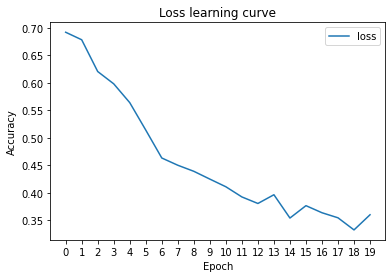

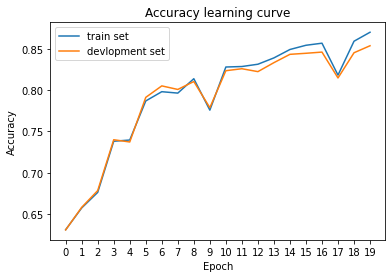

In [ ]:
import pandas as pd # Makes it easier to obtain the graphs in fewer lines of code.

# Plotting how the average loss evolves with each epoch
df = pd.DataFrame({"loss": loss_list})
df.plot(xlabel='Epoch', ylabel='Accuracy', title='Loss learning curve', xticks=range(len(loss_list)))

# Plotting how the accuracy on the train and dev sets evolves with each epoch
df = pd.DataFrame({"train set": train_accuracies, "devlopment set": dev_accuracies})
df.plot(xlabel='Epoch', ylabel='Accuracy', title='Accuracy learning curve', xticks=range(len(loss_list)))

In [ ]:
model.eval() # Tells PyTorch we are in evaluation/inference mode (can be useful if dropout is used, for instance).
model(batch_generator.turn_into_batch([preprocess(text) for text in ["This movie was terrible!!", "Pure gold!", "Bad.", "Not bad!"]]).to(model.device)) > 0.5

tensor([False,  True, False, False], device='cuda:0')

# Testing the use of a scheduler

I tried to use a scheduler to see whether it would improve performance or make my model learn faster. I first tested [ExponentialLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html#torch.optim.lr_scheduler.ExponentialLR) and then [OneCycleLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html#torch.optim.lr_scheduler.OneCycleLR), which is similar to what is recommended [here](https://towardsdatascience.com/hyper-parameter-tuning-techniques-in-deep-learning-4dad592c63c8), although I didn't do a learning rate range test to determine the best value for the maximum learning rate. However, at least with this hyperparameter combinations, I obtained a lower or similar performance with the scheduler, so I decided to leave it aside and focus on other hyperparameters for now.

In [ ]:
# With exponential scheduler

model = SentimentClassifier(embeddings, hidden_sizes=[20,10], freeze_embeddings=False, device='cuda')

# Tests the model on a couple of instance before training.
model.eval() # Tells PyTorch we are in evaluation/inference mode (can be useful if dropout is used, for instance).
print(model(batch_generator.turn_into_batch([preprocess(text) for text in ["This movie was terrible!!", "Pure gold!"]]).to(model.device)))

# Training procedure
learning_rate = 0.004
l2_reg = 0.0001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.99, weight_decay=l2_reg)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)  # Instanciates the scheduler, the gamma value is the one used in th Pytorch example
# Once the backward propagation has been done, just call the 'step' method (with no argument) of this object to update the parameters.
batch_size = 64
subset = None # Use an integer to train on a smaller portion of the training set, otherwise use None.
epoch_size = batch_generator.length("train") if(subset is None) else subset # In number of instances

nb_epoch = 20
epoch_id = 0 # Id of the current epoch
instances_processed = 0 # Number of instances trained on in the current epoch
epoch_loss = [] # Will contain the loss for each batch of the current epoch
loss_list = [] # The average loss for each epoch will be used to plot the learning curve
train_accuracies = [] # The accuracy on the train set for each epoch will be used to plot the learning curve
dev_accuracies = [] # The accuracy on the dev set for each epoch will be used to plot the learning curve
loss_fn = torch.nn.BCELoss(reduction='mean') # This loss function is adapted to the binary case
while(epoch_id < nb_epoch):
  model.train() # Tells PyTorch that we are in training mode (can be useful if dropout is used, for instance).
  
  model.zero_grad() # Makes sure the gradient is reinitialised to zero.
  
  batch = batch_generator.get_batch(batch_size, data_type="train", subset=subset) # The batch to train on at this iteration.
  
  ###################
  # (i) compute the prediction of the model (you might want to use ".to(model.device)" on the input of the model)
  prob = model(batch[0].to(model.device)) # Shape: (batch_size)

  # (ii) compute the loss (use an average over the batch) 
  targets = batch[1].float().to(model.device) # Casts booleans to floats so we can compare them to probabilities.
  loss = loss_fn(prob, targets)

  # (iii) call "backward" on the loss 
  loss.backward()

  # (iv) store the loss in "epoch_loss".
  epoch_loss.append(loss.item())

  ###################
  optimizer.step() # Updates the parameters.

  instances_processed += batch_size
  if(instances_processed > epoch_size): # If this iteration corresponds to the end of an epoch.
    scheduler.step()  # At the end of each epoch

    print(f"-- END OF EPOCH {epoch_id}.")
    print(f"Average loss: {sum(epoch_loss) / len(epoch_loss)}.")
    loss_list.append(sum(epoch_loss) / len(epoch_loss))

    # Evaluation
    model.eval() # Tells PyTorch we are in evaluation/inference mode (can be useful if dropout is used, for instance).
    with torch.no_grad(): # Deactivates Autograd (it is computationaly expensive and we don't need it here).
      accuracy = evaluation(model, "train")
      print(f"Accuracy on the train set: {accuracy}.")
      train_accuracies.append(accuracy)

      accuracy = evaluation(model, "dev")
      print(f"Accuracy on the dev set: {accuracy}.")
      dev_accuracies.append(accuracy)

    epoch_id += 1
    instances_processed -= epoch_size
    epoch_loss = []

tensor([0.5710, 0.5766], device='cuda:0', grad_fn=<SqueezeBackward0>)
-- END OF EPOCH 0.
Average loss: 0.6946723420465358.
Accuracy on the train set: 0.5.
Accuracy on the dev set: 0.5.
-- END OF EPOCH 1.
Average loss: 0.6905288366734371.
Accuracy on the train set: 0.6085333333333334.
Accuracy on the dev set: 0.60064.
-- END OF EPOCH 2.
Average loss: 0.655793148299533.
Accuracy on the train set: 0.6780266666666667.
Accuracy on the dev set: 0.6736.
-- END OF EPOCH 3.
Average loss: 0.5879208216691587.
Accuracy on the train set: 0.7467733333333333.
Accuracy on the dev set: 0.752.
-- END OF EPOCH 4.
Average loss: 0.5215172494027395.
Accuracy on the train set: 0.776.
Accuracy on the dev set: 0.77872.
-- END OF EPOCH 5.
Average loss: 0.544625538099341.
Accuracy on the train set: 0.7802133333333333.
Accuracy on the dev set: 0.78304.
-- END OF EPOCH 6.
Average loss: 0.4734743596547293.
Accuracy on the train set: 0.7923733333333334.
Accuracy on the dev set: 0.79232.
-- END OF EPOCH 7.
Average lo

In [ ]:
# With one cylce learning rate scheduler

model = SentimentClassifier(embeddings, hidden_sizes=[20,10], freeze_embeddings=False, device='cuda')

# Tests the model on a couple of instance before training.
model.eval() # Tells PyTorch we are in evaluation/inference mode (can be useful if dropout is used, for instance).
print(model(batch_generator.turn_into_batch([preprocess(text) for text in ["This movie was terrible!!", "Pure gold!"]]).to(model.device)))

# Training procedure
learning_rate = 0.004
l2_reg = 0.0001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.99, weight_decay=l2_reg)
# Once the backward propagation has been done, just call the 'step' method (with no argument) of this object to update the parameters.
batch_size = 64
subset = None # Use an integer to train on a smaller portion of the training set, otherwise use None.
epoch_size = batch_generator.length("train") if(subset is None) else subset # In number of instances

nb_epoch = 20
epoch_id = 0 # Id of the current epoch
instances_processed = 0 # Number of instances trained on in the current epoch
epoch_loss = [] # Will contain the loss for each batch of the current epoch
loss_list = [] # The average loss for each epoch will be used to plot the learning curve
train_accuracies = [] # The accuracy on the train set for each epoch will be used to plot the learning curve
dev_accuracies = [] # The accuracy on the dev set for each epoch will be used to plot the learning curve
loss_fn = torch.nn.BCELoss(reduction='mean') # This loss function is adapted to the binary case

# The scheduler is created here because epoch_size, batch_size and nb_epoch must be defined
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=int(epoch_size/batch_size)+1, epochs=nb_epoch)

while(epoch_id < nb_epoch):
  model.train() # Tells PyTorch that we are in training mode (can be useful if dropout is used, for instance).
  
  model.zero_grad() # Makes sure the gradient is reinitialised to zero.
  
  batch = batch_generator.get_batch(batch_size, data_type="train", subset=subset) # The batch to train on at this iteration.
  
  ###################
  # (i) compute the prediction of the model (you might want to use ".to(model.device)" on the input of the model)
  prob = model(batch[0].to(model.device)) # Shape: (batch_size)

  # (ii) compute the loss (use an average over the batch) 
  targets = batch[1].float().to(model.device) # Casts booleans to floats so we can compare them to probabilities.
  loss = loss_fn(prob, targets)

  # (iii) call "backward" on the loss 
  loss.backward()

  # (iv) store the loss in "epoch_loss".
  epoch_loss.append(loss.item())

  ###################
  optimizer.step() # Updates the parameters.
  scheduler.step() # After each batch is processed

  instances_processed += batch_size
  if(instances_processed > epoch_size): # If this iteration corresponds to the end of an epoch.
    print(f"-- END OF EPOCH {epoch_id}.")
    print(f"Average loss: {sum(epoch_loss) / len(epoch_loss)}.")
    loss_list.append(sum(epoch_loss) / len(epoch_loss))

    # Evaluation
    model.eval() # Tells PyTorch we are in evaluation/inference mode (can be useful if dropout is used, for instance).
    with torch.no_grad(): # Deactivates Autograd (it is computationaly expensive and we don't need it here).
      accuracy = evaluation(model, "train")
      print(f"Accuracy on the train set: {accuracy}.")
      train_accuracies.append(accuracy)

      accuracy = evaluation(model, "dev")
      print(f"Accuracy on the dev set: {accuracy}.")
      dev_accuracies.append(accuracy)

    epoch_id += 1
    instances_processed -= epoch_size
    epoch_loss = []

tensor([0.4464, 0.4410], device='cuda:0', grad_fn=<SqueezeBackward0>)
-- END OF EPOCH 0.
Average loss: 0.6965289181002985.
Accuracy on the train set: 0.5.
Accuracy on the dev set: 0.5.
-- END OF EPOCH 1.
Average loss: 0.6935006121726573.
Accuracy on the train set: 0.5032.
Accuracy on the dev set: 0.4984.
-- END OF EPOCH 2.
Average loss: 0.6928390870728998.
Accuracy on the train set: 0.5.
Accuracy on the dev set: 0.5.
-- END OF EPOCH 3.
Average loss: 0.6924171280942273.
Accuracy on the train set: 0.5.
Accuracy on the dev set: 0.5.
-- END OF EPOCH 4.
Average loss: 0.6912860170566181.
Accuracy on the train set: 0.64272.
Accuracy on the dev set: 0.6352.
-- END OF EPOCH 5.
Average loss: 0.6873036102223314.
Accuracy on the train set: 0.5800533333333333.
Accuracy on the dev set: 0.57888.
-- END OF EPOCH 6.
Average loss: 0.6753050752060406.
Accuracy on the train set: 0.65744.
Accuracy on the dev set: 0.65568.
-- END OF EPOCH 7.
Average loss: 0.6423421083049969.
Accuracy on the train set: 0.671

# Hyperparameter tuning

Looking for the set of hyperparameters that maximises the accuracy on the development set.

## Early stopping

- Number of epochs

From the learning curve computed previously, I was not completely sure whether we had reached a plateau or whether performance on the development set could still be increased (slowly) by training for more epochs. So, I implemented early stopping. With a patience of 5, I trained until epoch 31 and was able to get 1.5 percent points more on the accuracy, without changing the other hyperparameters.

## Grid search

For some other hyperparameters, I used grid search to look for the best combination of values. Among the values I have tested, the best combination was 'learning rate': 0.004, 'weight decay': 0.0001, 'momentum': 0.99, 'embedding size': 300, with and accuracy of 88,432%.

- Learning rate
- Weight decay
- Momentum
- Embeddings size

I could also have changed the batch size, but I thought that this would have bigger impact on the efficiency of training than on the accuracy, so, I didn't change it for now. Another possibility would have been to test other architectures (a different number of layers or different layer sizes).

In [ ]:
(vocabulary_50, embeddings_50) = get_glove(dim=50, vocabulary=vocabulary)
batch_generator_500 = BatchGenerator(dataset=dataset, vocabulary=vocabulary_50)

(vocabulary_100, embeddings_100) = get_glove(dim=100, vocabulary=vocabulary)
batch_generator_100 = BatchGenerator(dataset=dataset, vocabulary=vocabulary_100)

(vocabulary_200, embeddings_200) = get_glove(dim=200, vocabulary=vocabulary)
batch_generator_200 = BatchGenerator(dataset=dataset, vocabulary=vocabulary_200)

(vocabulary_300, embeddings_300) = get_glove(dim=300, vocabulary=vocabulary)
batch_generator_300 = BatchGenerator(dataset=dataset, vocabulary=vocabulary_300)

Reading GloVe embeddings.
(GloVe embeddings loaded.)

Reading GloVe embeddings.


In [ ]:
learning_rates = [0.4, 0.04, 0.004, 0.0004]
l2_regs = [0.0001, 0.00001, 0.000001, 0]
momentums = [0, 0.6, 0.8, 0.99]
embedding_sizes = [(batch_generator_100, embeddings_100, 100), (batch_generator_200, embeddings_200, 200), (batch_generator_300, embeddings_300, 300), (batch_generator_50, embeddings_50, 50)]

In [ ]:
# Training procedure

# Hyperparameter tuning

best_hyperparameters = {} # for comparing hyperparameter values
best_accuracy = 0 # for comparing hyperparameter values
for learning_rate in learning_rates:
  for l2_reg in l2_regs:
    for momentum in momentums:
      for batch_generator, embeddings, embed_dim in embedding_sizes:
        model = SentimentClassifier(embeddings, hidden_sizes=[20,10], freeze_embeddings=False, device='cuda') # Must be restarted every time
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=l2_reg) 
        patience = 5 # nb of epochs with decreased performance to wait for before interrupting training

        # Once the backward propagation has been done, just call the 'step' method (with no argument) of this object to update the parameters.
        batch_size = 64
        subset = None # Use an integer to train on a smaller portion of the training set, otherwise use None.
        epoch_size = batch_generator.length("train") if(subset is None) else subset # In number of instances

        dev_accuracies = [] # Used for early stopping
        nb_epoch = 50
        epoch_id = 0 # Id of the current epoch
        instances_processed = 0 # Number of instances trained on in the current epoch
        epoch_loss = [] # Will contain the loss for each batch of the current epoch
        loss_fn = torch.nn.BCELoss(reduction='mean') # This loss function is adapted to the binary case
        while(epoch_id < nb_epoch):
          model.train() # Tells PyTorch that we are in training mode (can be useful if dropout is used, for instance).
          
          model.zero_grad() # Makes sure the gradient is reinitialised to zero.
          
          batch = batch_generator.get_batch(batch_size, data_type="train", subset=subset) # The batch to train on at this iteration.
          
          ###################
          # (i) compute the prediction of the model (you might want to use ".to(model.device)" on the input of the model)
          prob = model(batch[0].to(model.device)) # Shape: (batch_size)

          # (ii) compute the loss (use an average over the batch) 
          targets = batch[1].float().to(model.device) # Casts booleans to floats so we can compare them to probabilities.
          loss = loss_fn(prob, targets)

          # (iii) call "backward" on the loss 
          loss.backward()

          # (iv) store the loss in "epoch_loss".
          epoch_loss.append(loss.item())

          ###################
          optimizer.step() # Updates the parameters.

          instances_processed += batch_size
          if(instances_processed > epoch_size): # If this iteration corresponds to the end of an epoch.

            # Evaluation
            model.eval() # Tells PyTorch we are in evaluation/inference mode (can be useful if dropout is used, for instance).
            with torch.no_grad(): # Deactivates Autograd (it is computationaly expensive and we don't need it here).
              accuracy = evaluation(model, "dev")
              dev_accuracies.append(accuracy)
              if accuracy > best_accuracy:
                print(f"Best accuracy so far: {accuracy}!")
                best_accuracy = accuracy
                best_hyperparameters["learning rate"] = learning_rate
                best_hyperparameters["weight decay"] = l2_reg
                best_hyperparameters["momentum"] = momentum
                best_hyperparameters["embedding size"] = embed_dim

              # Early stopping procedure
              if epoch_id >= patience:
                early_stop = True
                # We are testing whether the accuracy on the dev set obtained patience-1 epochs ago is better then all the following ones
                accuracy_to_test = dev_accuracies[-patience-1]  # Accuracy obtained patience+1 epochs ago
                for accuracy in dev_accuracies[-patience:]: # All following accuracies
                  if accuracy_to_test < accuracy:
                    early_stop = False
                if early_stop:
                  break

            epoch_id += 1
            instances_processed -= epoch_size
            epoch_loss = []
        
        print(f"Learning rate {learning_rate}, weight decay {l2_reg}, momentum {momentum}, embedding size: {embed_dim}")
        print(f"Stopped at epoch {epoch_id}")
        print(f"Best accuracy: {max(dev_accuracies)}\n")

print(best_hyperparameters)
print(best_accuracy)

Best accuracy so far: 0.66672!
Learning rate 0.4, weight decay 0.0001, momentum 0.8, embedding size: 100
Stopped ate epoch 5
Best accuracy: 0.66672

Learning rate 0.4, weight decay 0.0001, momentum 0.8, embedding size: 200
Stopped ate epoch 5
Best accuracy: 0.5

Learning rate 0.4, weight decay 0.0001, momentum 0.8, embedding size: 300
Stopped ate epoch 5
Best accuracy: 0.5

Learning rate 0.4, weight decay 0.0001, momentum 0.99, embedding size: 100
Stopped ate epoch 5
Best accuracy: 0.5

Learning rate 0.4, weight decay 0.0001, momentum 0.99, embedding size: 200
Stopped ate epoch 5
Best accuracy: 0.5

Learning rate 0.4, weight decay 0.0001, momentum 0.99, embedding size: 300
Stopped ate epoch 5
Best accuracy: 0.5

Best accuracy so far: 0.74864!
Best accuracy so far: 0.78752!
Best accuracy so far: 0.80208!
Best accuracy so far: 0.82592!
Best accuracy so far: 0.83424!
Best accuracy so far: 0.83632!
Best accuracy so far: 0.83648!
Best accuracy so far: 0.84576!
Best accuracy so far: 0.84928!